In [1]:
import ee
import folium 
import geehydro
import numpy as np
import pandas as pd
import proplot as plot 
import matplotlib.pyplot as plt 
from ipygee import*
from pandas.plotting import register_matplotlib_converters

In [2]:
# Google earth engine
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWiEfPJ5oDjoVd1WLsScvZ7Lhr6H8Tptgtz3QMIrwkDs31P9X1nwhoc

Successfully saved authorization token.


# Section 1: Downloading Malawi Veg Indices and their Visualization
### To download and save indices of multiple countries scroll down to "Section 2"

In [3]:
# collection = ee.ImageCollection('MODIS/006/MOD13A1').select('NDVI')

# coordinates of country boundaries
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

# Select Malawi feature from countries.
mal = ee.Feature(countries.filter(ee.Filter.eq('country_na', 'Malawi')).first())
# print("Malawi: ",mal)

In [ ]:
# # Use a function to iterate through months and calculate average NDVI
# months = ee.List.sequence(1, 12)
# # print("months",months)
# years = ee.List.sequence(2010, 2020)
# # print("years",years)

In [4]:
# Only run this cell if need to visualise on map
# Need to enter coordinates near the country to visual the country on the map
# e.g Malawi= 13.2543° S, 34.3015° E
Map = folium.Map(location=[-13.25, 34.5], zoom_start=8)
# superimpose malawi onto map
Map.addLayer(mal)

In [5]:
# display map
Map

In [6]:
# MODIS MOD13Q1
modis = ee.ImageCollection('MODIS/006/MOD13Q1')
modis = modis.filterDate(ee.DateRange('2000-01-01','2009-12-01'))

In [7]:
# select EVI and NDVI
evi = modis.select('EVI')
ndvi = modis.select('NDVI')

In [8]:
def scale_factor(image):
# scale factor for the MODIS MOD13Q1 product (scale factor taken from user guide)
    return image.multiply(0.0001).copyProperties(image,['system:time_start'])

# mapping function to multiply by the scale factor
scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [9]:
# mean NDVI in the Malawi
Map.addLayer(scaled_ndvi.mean().clip(mal), vis_params={'min': 0,'max': 1,'palette': ['red', 'yellow','green']})

In [10]:
# visualise the NDVI on map
Map

In [11]:
mal_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                                   'region': mal,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})
# to plot widget
# mal_ndvi.renderWidget(width='50%')

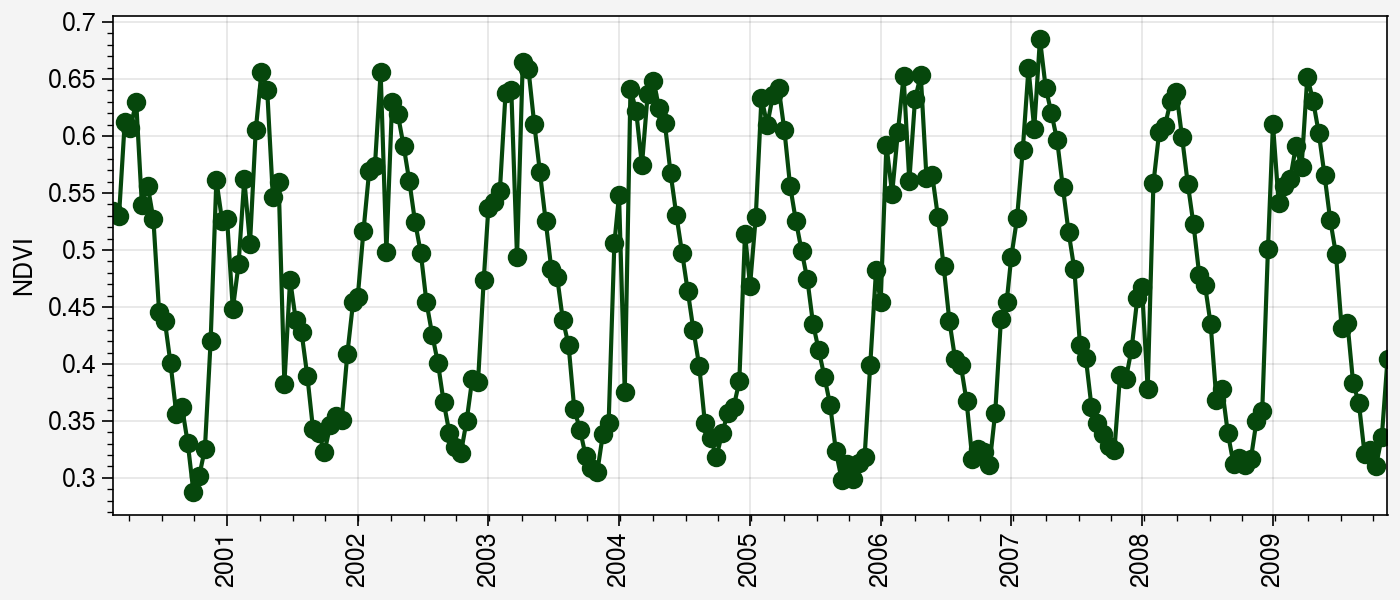

In [12]:
# mal_ndvi.dataframe can now be used as a pandas dataframe
fig, ax = plot.subplots(figsize=(7, 3), tight=True)
ax.plot(mal_ndvi.dataframe.index, mal_ndvi.dataframe['NDVI'],
        color='forest green', marker='o')
plot.show()

In [13]:
# the data is 16-day sampled data
mal_ndvi.dataframe.head()

,NDVI
2000-02-18,0.534256
2000-03-05,0.529860
2000-03-21,0.612170
2000-04-06,0.607110
2000-04-22,0.630168


In [14]:
mal_ndvi.dataframe.tail()

,NDVI
2009-09-14,0.320998
2009-09-30,0.324082
2009-10-16,0.310822
2009-11-01,0.335484
2009-11-17,0.403919


In [15]:
# Repeat with EVI
mal_evi = chart.Image.series(**{'imageCollection': scaled_evi,
                                   'region': mal,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})

In [16]:
# Convert 16-day sampled data to monthly averages
malawi_evi_monthly = mal_evi.dataframe.groupby(pd.Grouper(freq="M")).mean()
malawi_ndvi_monthly = mal_ndvi.dataframe.groupby(pd.Grouper(freq="M")).mean()

In [17]:
malawi_evi_monthly.head()

,EVI
2000-02-29,0.362193
2000-03-31,0.373737
2000-04-30,0.381332
2000-05-31,0.308848
2000-06-30,0.257063


In [18]:
malawi_evi_monthly.tail()

,EVI
2009-07-31,0.216556
2009-08-31,0.188016
2009-09-30,0.169807
2009-10-31,0.169293
2009-11-30,0.211458


In [19]:
# len(malawi_evi_monthly.index)

In [20]:
# malawi_evi_monthly.shape

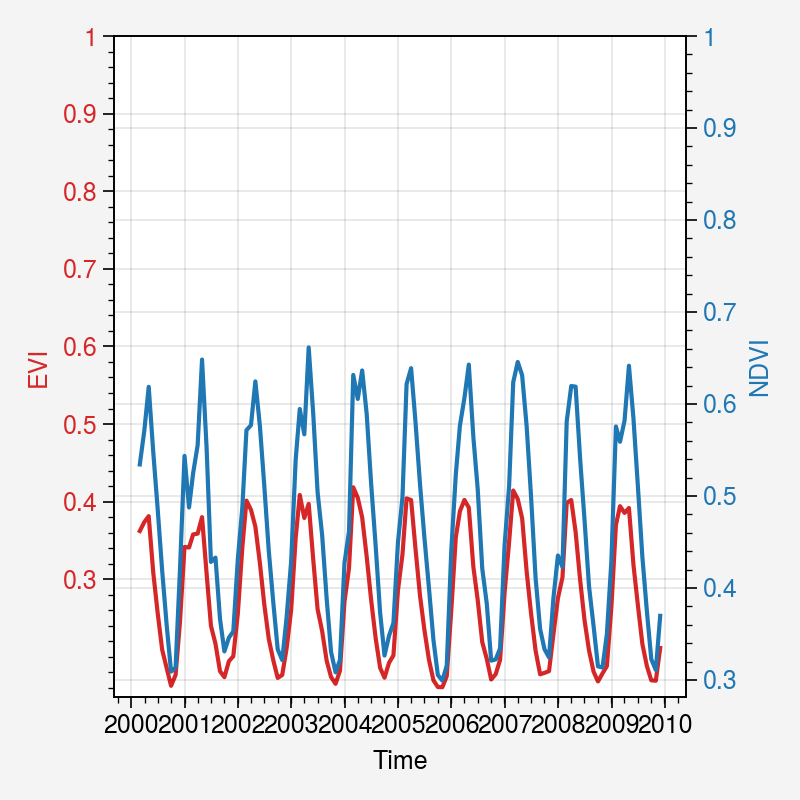

In [21]:
# x axis
time = malawi_evi_monthly.index

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('EVI',color=color)
ax1.plot(time, malawi_evi_monthly.iloc[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('NDVI', color=color)
ax2.plot(time, malawi_ndvi_monthly.iloc[:,0],color=color)
ax2.tick_params(axis='y', labelcolor=color)

# ax1.set_xlabel('Time')
# ax1.set_ylabel('EVI')
# ax2.set_ylabel('NDVI')
# plt.legend()

ax1.set_yticks(np.arange(0.3, 1.1, 0.1))
ax2.set_yticks(np.arange(0.3, 1.1, 0.1))

fig.tight_layout()
plt.show()

In [8]:
from pathlib import Path

# country='Malawi'
# date_range="2000-2009"
# fp_NDVI = "NDVI_"+date_range+'.csv'
# fp_EVI = "EVI_"+date_range+'.csv'
# filepath_NDVI = Path(Path.cwd()/country/fp_NDVI)
# filepath_EVI = Path(Path.cwd()/country/fp_EVI)



In [23]:
# save to csv
# malawi_ndvi_monthly.to_csv(filepath_NDVI)

In [24]:
# malawi_evi_monthly.to_csv(filepath_EVI)

# Section 2: To download Multiple Countries

In [9]:
import os

In [28]:
# coordinates of country boundaries
countries_cor = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
modis = ee.ImageCollection('MODIS/006/MOD13Q1')

def image_to_series(scaled_index,country):
    vi = chart.Image.series(**{'imageCollection': scaled_index,
                               'region': country,
                               'reducer': ee.Reducer.mean(),
                               'scale': 1000,
                               'xProperty': 'system:time_start'})
    return vi
#     c_evi = chart.Image.series(**{'imageCollection': scaled_evi,
#                                'region': country,
#                                'reducer': ee.Reducer.mean(),
#                                'scale': 1000,
#                                'xProperty': 'system:time_start'})
#     return vi
    
    
def extract_data(country_name, countries_cor, modis, dates):
    # Select Malawi feature from countries.
    country = ee.Feature(countries_cor.filter(ee.Filter.eq('country_na', country_name)).first())
    mod = modis.filterDate(ee.DateRange(dates[0],dates[1]))
    evi = mod.select('EVI')
    ndvi = mod.select('NDVI')
    scaled_evi = evi.map(scale_factor)
    scaled_ndvi = ndvi.map(scale_factor)
    c_ndvi = image_to_series(scaled_ndvi, country)
    c_evi = image_to_series(scaled_evi, country)
    c_evi_monthly = c_evi.dataframe.groupby(pd.Grouper(freq="M")).mean()
    c_ndvi_monthly = c_ndvi.dataframe.groupby(pd.Grouper(freq="M")).mean()
    return c_ndvi_monthly, c_evi_monthly
    
def scale_factor(image):
# scale factor for the MODIS MOD13Q1 product
    return image.multiply(0.0001).copyProperties(image,['system:time_start'])

dates = [['2000-01-01','2002-12-30'],
         ['2002-01-01','2004-12-30'],
         ['2004-01-01','2006-12-30'],
         ['2006-01-01','2008-01-01'],
         ['2008-01-01','2010-12-30'],
         ['2010-01-01','2012-12-30'],
         ['2012-01-01','2014-01-01'],
         ['2014-01-01','2016-12-30'],
         ['2016-01-01','2018-12-30'],
         ['2018-01-01','2020-01-01'],
         ['2020-01-01','2022-12-30']
        ]
req_countries = ['Gambia'] 

#  Memory 

# Egypt, 'Sourth Africa',

# Finished:
# 'Algeria',
#  'Benin',
#  'Botswana',
#  'Burkina Faso',
#  'Chad', 
# 'Gabon',
#  'Ghana',
#  'Kenya',
#  'Mali',
#  'Mauritania',
#  'Niger', 
# 'Senegal',
#  'Sierra Leone',
#  'Somalia',
#  'Zambia',
# 'Zimbabwe', 
# 'Burundi', 'Comoros', 'Djibouti',  'Equatorial Guinea', 'Eritrea',
#  'Guinea', 'Guinea-Bissau', 'Lesotho','Mauritius', 'Seychelles', 'Sudan', 'Togo', 'South Sudan','Madagascar', 'Mozambique', 'Cameroon', 'Nigeria',

# Error:
#  'Congo',

In [22]:
def concatenate_df(df1, df2, df3, df4):
    frames = [df1, df2,df3,df4]
    result = pd.concat(frames)
    return result
    
    

In [23]:
# for country in req_countries:
#     for date in dates:
#         ndvi,evi = extract_data(country,countries_cor,modis,date)
#         filename_NDVI = "NDVI_"+date[0]+'_'+date[1]+'.csv'
#         filename_EVI = "EVI_"+date[0]+'_'+date[1]+'.csv'
#         path = str(Path(Path.cwd()/country))
#         # Check whether the specified path exists or not
#         isExist = os.path.exists(path)
#         if not isExist:
#             # Create a new directory because it does not exist 
#             os.makedirs(path)
#         ndvi.to_csv(path+'/'+filename_NDVI)
#         evi.to_csv(path+'/'+filename_EVI)
    

In [29]:
for country_name in req_countries:
    print(country_name)
    list1 = []
    list2 = []
    for i in range(len(dates)):
        print('Getting data[',i,']', dates[i])
        ndvi, evi = extract_data(country_name,countries_cor,modis,dates[i])
        list1.append(ndvi)
        list2.append(evi)
    ndvi = pd.concat(list1)
    evi = pd.concat(list2)
    
#     print('Getting data[0]')
#     ndvi1,evi1 = extract_data(country_name,countries_cor,modis,dates[0])
#     print('Getting data[1]')
#     ndvi2,evi2 = extract_data(country_name,countries_cor,modis,dates[1])
#     print('Getting data[2]')
#     ndvi3,evi3 = extract_data(country_name,countries_cor,modis,dates[2])
#     print('Getting data[3]')
#     ndvi4,evi4 = extract_data(country_name,countries_cor,modis,dates[3])
#     ndvi = concatenate_df(ndvi1,ndvi2,ndvi3,ndvi4)
#     evi = concatenate_df(evi1,evi2,evi3,evi4)
    filename_NDVI = "NDVI_"+dates[0][0]+'_'+dates[3][1]+'.csv'
    filename_EVI = "EVI_"+dates[0][0]+'_'+dates[3][1]+'.csv'
    path = str(Path(Path.cwd()/country_name))
    print("Saving Path:",path)
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(path)
    ndvi.to_csv(path+'/'+filename_NDVI)
    evi.to_csv(path+'/'+filename_EVI)

Gambia
Getting data[ 0 ] ['2000-01-01', '2002-12-30']


EEException: Element.geometry: Parameter 'feature' is required.

In [76]:
# ndvi = concatenate_df(ndvi1,ndvi2)
# evi = concatenate_df(evi1,evi2)
# filename_NDVI = "NDVI_"+dates[0][0]+'_'+dates[1][1]+'.csv'
# filename_EVI = "EVI_"+dates[0][0]+'_'+dates[1][1]+'.csv'
# path = str(Path(Path.cwd()/country_name))
# # Check whether the specified path exists or not
# isExist = os.path.exists(path)
# if not isExist:
#     # Create a new directory because it does not exist 
#     os.makedirs(path)
# ndvi.to_csv(path+'/'+filename_NDVI)
# evi.to_csv(path+'/'+filename_EVI)

In [135]:
# ndvi1,evi1 = extract_data(country_name,countries_cor,modis,dates[0])
# ndvi2,evi2 = extract_data(country_name,countries_cor,modis,dates[1])
# ndvi3,evi3 = extract_data(country_name,countries_cor,modis,dates[2])
# ndvi4,evi4 = extract_data(country_name,countries_cor,modis,dates[3])
# ndvi = concatenate_df(ndvi1,ndvi2,ndvi3,ndvi4)
# evi = concatenate_df(evi1,evi2,evi3,evi4)
# filename_NDVI = "NDVI_"+dates[0][0]+'_'+dates[3][1]+'.csv'
# filename_EVI = "EVI_"+dates[0][0]+'_'+dates[3][1]+'.csv'
# path = str(Path(Path.cwd()/country_name))
# # Check whether the specified path exists or not
# isExist = os.path.exists(path)
# if not isExist:
#     # Create a new directory because it does not exist 
#     os.makedirs(path)
# ndvi.to_csv(path+'/'+filename_NDVI)
# evi.to_csv(path+'/'+filename_EVI)

### Double checking if the data is correct

In [129]:
ndvi4

,NDVI
2016-01-31,0.198062
2016-02-29,0.204815
2016-03-31,0.200237
2016-04-30,0.181671
2016-05-31,0.156514
...,...
2021-08-31,0.147342
2021-09-30,0.148515
2021-10-31,0.156120
2021-11-30,0.171457


In [63]:
ndvi1.head()

,NDVI
2000-02-29,0.609958
2000-03-31,0.636947
2000-04-30,0.647880
2000-05-31,0.588064
2000-06-30,0.513630


In [64]:
ndvi1.tail()

,NDVI
2009-08-31,0.393209
2009-09-30,0.398861
2009-10-31,0.450012
2009-11-30,0.538952
2009-12-31,0.660010


In [65]:
ndvi2.head()

,NDVI
2010-01-31,0.680876
2010-02-28,0.591141
2010-03-31,0.692829
2010-04-30,0.660276
2010-05-31,0.594959


In [66]:
ndvi2.tail()

,NDVI
2021-08-31,0.409694
2021-09-30,0.416903
2021-10-31,0.475444
2021-11-30,0.522475
2021-12-31,0.592680


In [130]:
frames = [ndvi1, ndvi2,ndvi3,ndvi4]
ndvi_r = pd.concat(frames)


In [131]:
ndvi_r

,NDVI
2000-02-29,0.209701
2000-03-31,0.203764
2000-04-30,0.180286
2000-05-31,0.151341
2000-06-30,0.143638
...,...
2021-08-31,0.147342
2021-09-30,0.148515
2021-10-31,0.156120
2021-11-30,0.171457


In [134]:
ndvi

,NDVI
2000-02-29,0.209701
2000-03-31,0.203764
2000-04-30,0.180286
2000-05-31,0.151341
2000-06-30,0.143638
...,...
2021-08-31,0.147342
2021-09-30,0.148515
2021-10-31,0.156120
2021-11-30,0.171457


In [72]:
ndvi2

,NDVI
2010-01-31,0.680876
2010-02-28,0.591141
2010-03-31,0.692829
2010-04-30,0.660276
2010-05-31,0.594959
...,...
2021-08-31,0.409694
2021-09-30,0.416903
2021-10-31,0.475444
2021-11-30,0.522475


In [159]:
ndvi.iloc[:,0]

2000-02-29    0.573375
2000-03-31    0.608626
2000-04-30    0.634246
2000-05-31    0.568838
2000-06-30    0.480478
                ...   
2021-08-31    0.442430
2021-09-30    0.496802
2021-10-31    0.502759
2021-11-30    0.576605
2021-12-31    0.641217
Freq: M, Name: NDVI, Length: 263, dtype: float64

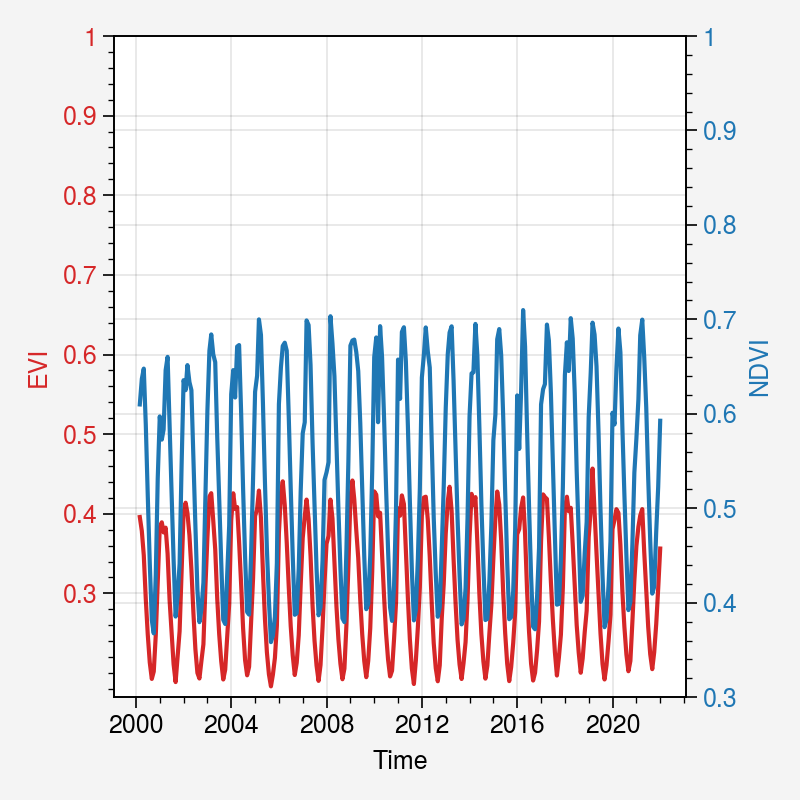

In [77]:
time = evi.index

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('EVI',color=color)
ax1.plot(time, evi.iloc[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('NDVI', color=color)
ax2.plot(time, ndvi.iloc[:,0],color=color)
ax2.tick_params(axis='y', labelcolor=color)

# ax1.set_xlabel('Time')
# ax1.set_ylabel('EVI')
# ax2.set_ylabel('NDVI')
# plt.legend()

ax1.set_yticks(np.arange(0.3, 1.1, 0.1))
ax2.set_yticks(np.arange(0.3, 1.1, 0.1))

fig.tight_layout()
plt.show()

In [89]:
country = ee.Feature(countries_cor.filter(ee.Filter.eq('country_na', country_name)).first())

In [90]:
Map = folium.Map(location=[-13.13, 27.84], zoom_start=8)
# superimpose malawi onto map
Map.addLayer(country)

In [91]:
Map

In [92]:
mod = modis.filterDate(ee.DateRange(dates[0][0],dates[0][1]))
evi = mod.select('EVI')
ndvi = mod.select('NDVI')
scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)
Map.addLayer(scaled_ndvi.mean().clip(country), vis_params={'min': 0,'max': 1,'palette': ['red', 'yellow','green']})

In [93]:
Map

# Compare NDVI and EVI with Yield